In [ ]:
# prompt: link with google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/STM")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle

In [ ]:

df_feat = pd.read_csv('/content/drive/MyDrive/STM/encoded data/opamps-features.csv')
df_ref = pd.read_csv('/content/drive/MyDrive/STM/encoded data/opamps-xref.csv')

# Prétraitement

In [ ]:
categorical_columns = ["Supplier_Package"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

## Normalisation des données numériques

In [ ]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

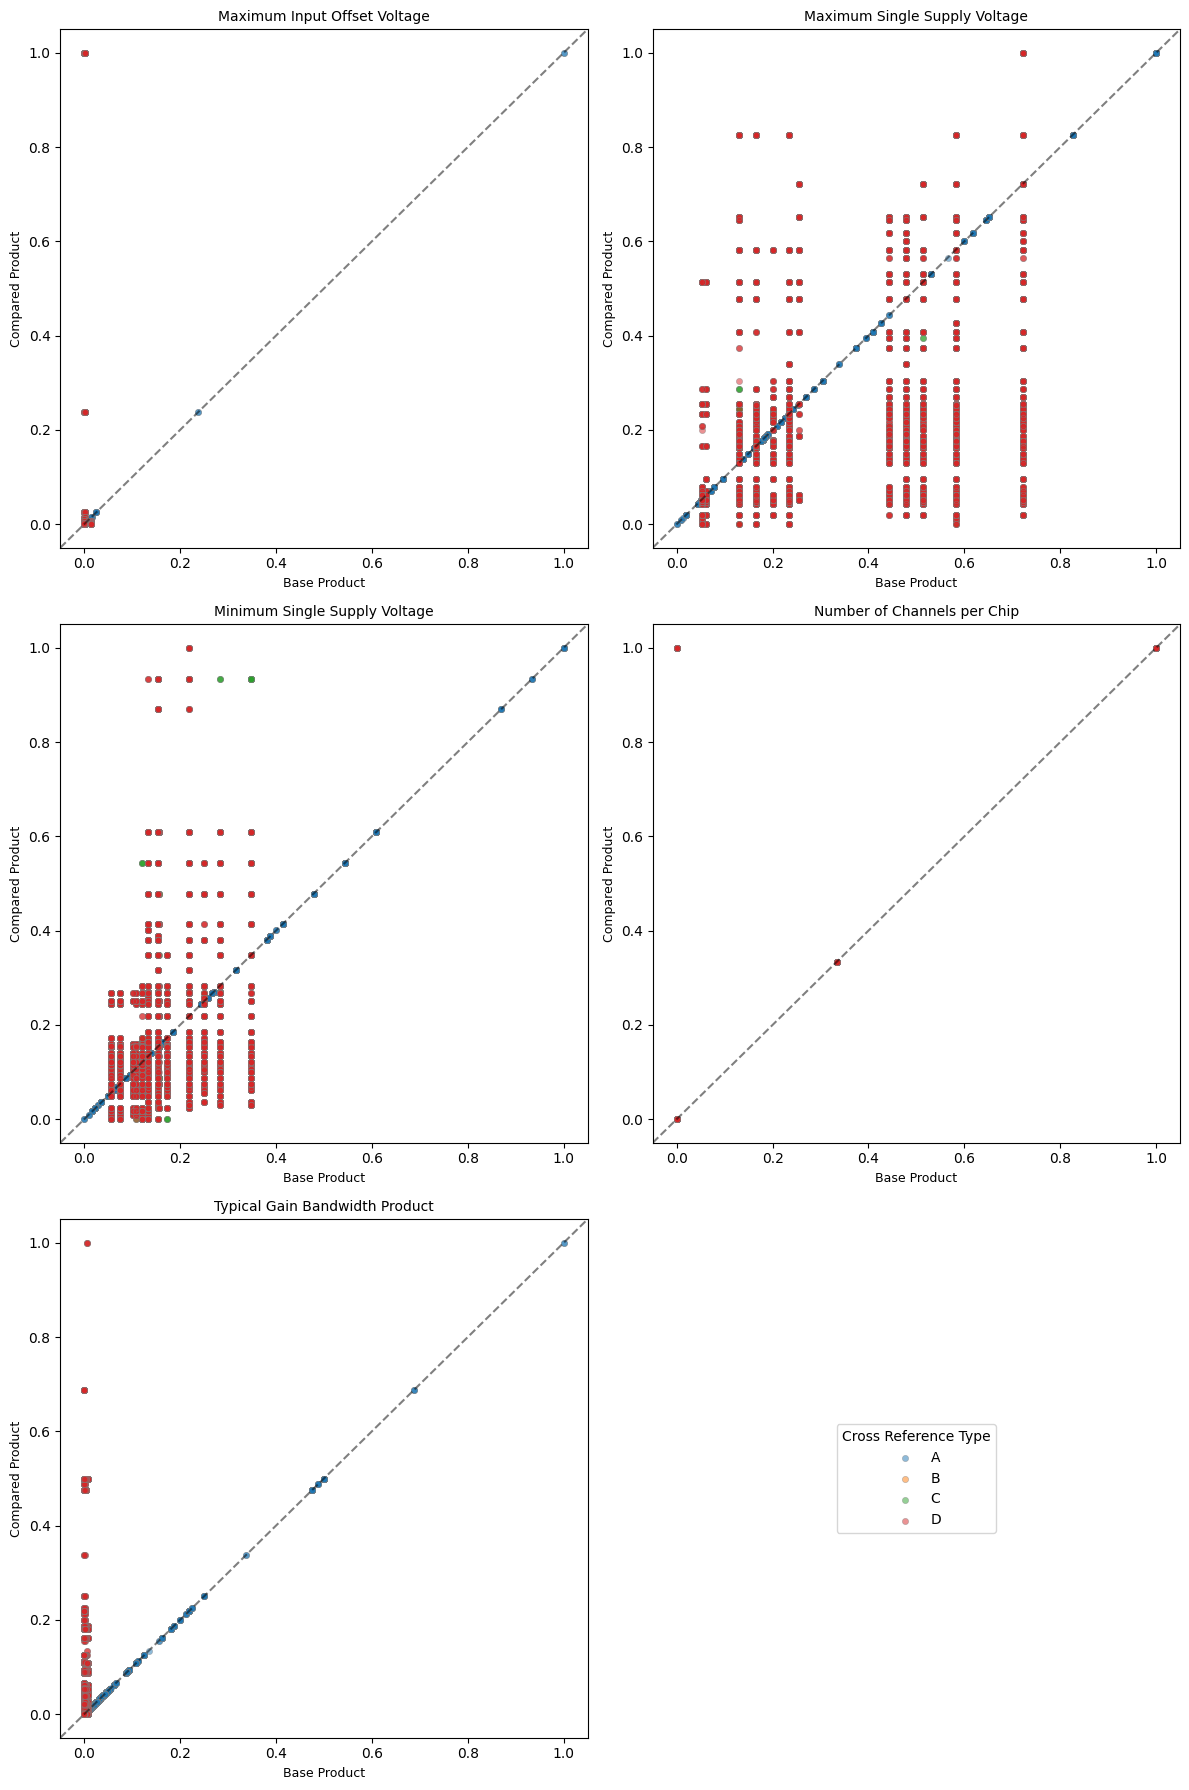

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.visualize(df,numerical_columns)

## Conversion de la Cross Reference Type en numerique

### Y : aleatoire gaussien

In [ ]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.65, 'D': 0.5}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

<module 'helper_functions.preprocess' from '/content/drive/MyDrive/STM/helper_functions/preprocess.py'>

### Y: fonction des distances (abs)

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_abs(df, base_means, spread,categorical_columns ,numerical_columns)


<Axes: xlabel='Closeness', ylabel='Density'>

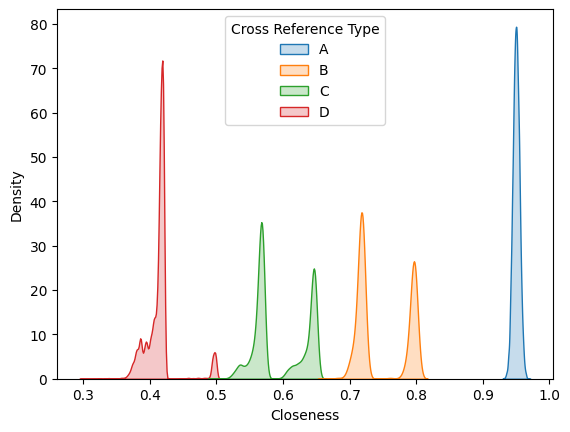

In [ ]:
# df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Y : distance power

In [ ]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Closeness'],
      dtype='object')

In [ ]:
base_means = { #neji
    'A': 0.95,  # High score for class A (most similar)
    'B': 0.75,
    'C': 0.55,
    'D': 0.35   # Low score for class D (least similar)
}
base_intervals = {
    "A": [0.88 , 0.98],
    "B": [0.7 , 0.8],
    "C" : [0.5, 0.65],
    "D" :[0.3, 0.45]
}

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_pow(df, base_intervals,categorical_columns ,numerical_columns,p=0.3)


epsilon_A shape: (18356,)


<Axes: xlabel='Closeness', ylabel='Density'>

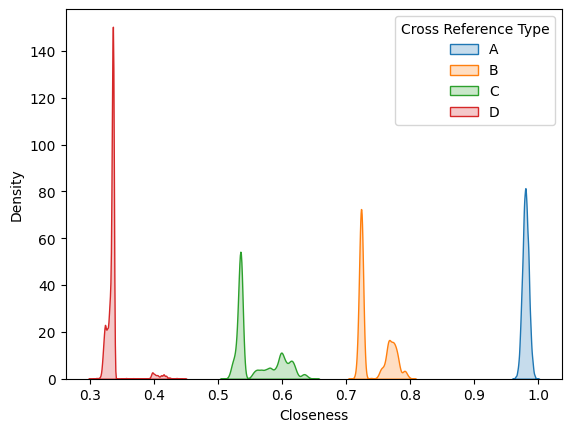

In [ ]:

sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
# for col in categorical_columns:
#   df["distance_"+col] = df[col] == df[col+"_comp"]
#   df["distance_"+col] =1- df["distance_"+col].astype(int)
# for col in numerical_columns:
#   df["distance_"+col] = np.abs(df[col] - df[col+"_comp"])
# df["distance"] = df[["distance_"+col for col in categorical_columns+numerical_columns]].sum(axis=1)

### Y : sigmoid

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_sigma(df, base_intervals,categorical_columns ,numerical_columns,k=20, midpoint=0.5)


<Axes: xlabel='Closeness', ylabel='Density'>

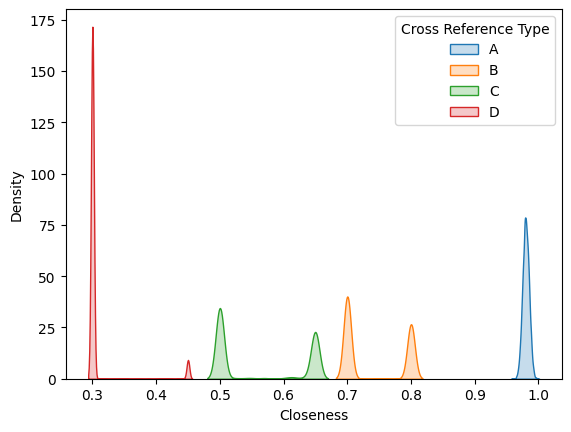

In [ ]:

sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Y : exponentielle

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_exp(df, base_intervals,categorical_columns ,numerical_columns,k=0.1)


<Axes: xlabel='Closeness', ylabel='Density'>

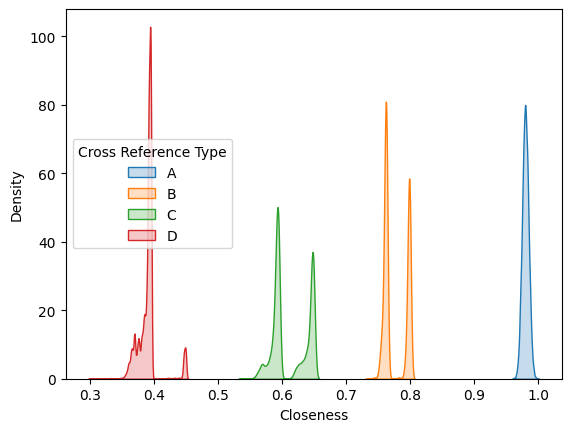

In [ ]:

sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

## Division de la Dataset

In [ ]:
df_train, df_validation, df_test = pp.split_dataframe(df)

In [ ]:
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_validation)}")
print(f"Test size: {len(df_test)}")

Train size: 818553
Validation size: 51159
Test size: 153480


## Resolution du probleme d'equilibre des classes

Cela doit être fait sur seuleument la base d'entrainnement, sinon ça peut pas refletter la performance relle des modeles

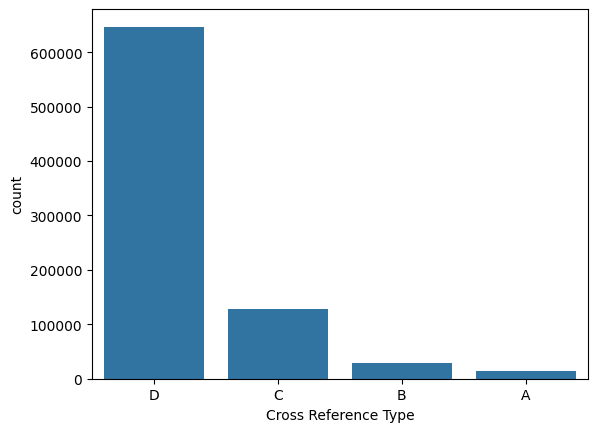

In [ ]:
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

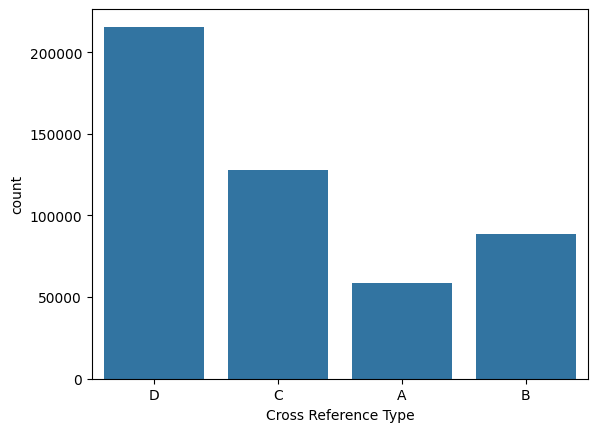

In [ ]:
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

# Splitting Data

In [ ]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp", "Cross Reference Type"]

In [ ]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Closeness'],
      dtype='object')

In [ ]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp",'distance_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance' , "Cross Reference Type"]

In [ ]:
X_train = df_train.drop(columns=columns_to_drop)
X_validation = df_validation.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

y_train = df_train['Closeness']
y_validation = df_validation['Closeness']
y_test = df_test['Closeness']

In [ ]:
categorical_columns+=[i +"_comp" for i in categorical_columns]

In [ ]:
categorical_columns

['Supplier_Package', 'Supplier_Package_comp']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),

    ],
    remainder='passthrough'
)

# ML models

In [ ]:
results = {}

## Linear Regression / witghout manufacturer

In [ ]:
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [ ]:
pipeline.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

NameError: name 'pipeline' is not defined

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix LR sans manufacturer.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [10:33<00:00, 28.95it/s]


'closeness_matrix LR sans manufacturer.npy'

In [ ]:
data = np.load("closeness_matrix LR sans manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix LR.png")

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix_nomodel(df_feat_scaled, df)

Building closeness matrix: 100%|██████████| 1023192/1023192 [00:41<00:00, 24773.14it/s]


'closeness_matrix.npy'

In [ ]:
data = np.load("closeness_matrix.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix data.png")

In [ ]:
sns.heatmap(data, annot=False, cmap="viridis", linewidths=0.5)

In [ ]:
unique_values, counts = np.unique(data, return_counts=True)

Buffered data was truncated after reaching the output size limit.

<Axes: ylabel='Count'>

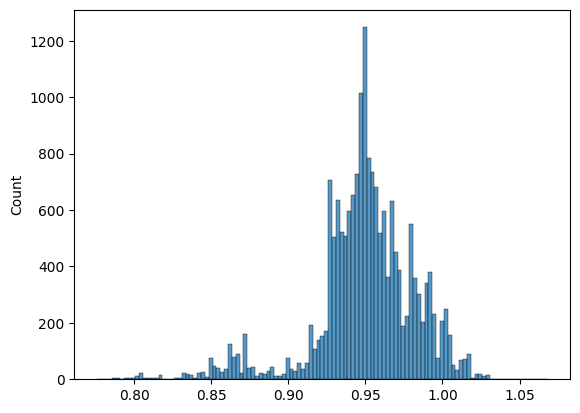

In [ ]:

sns.histplot(data.diagonal()) #repartition des score de similarité d'un produit avec lui même (doit être proche de 0.9)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

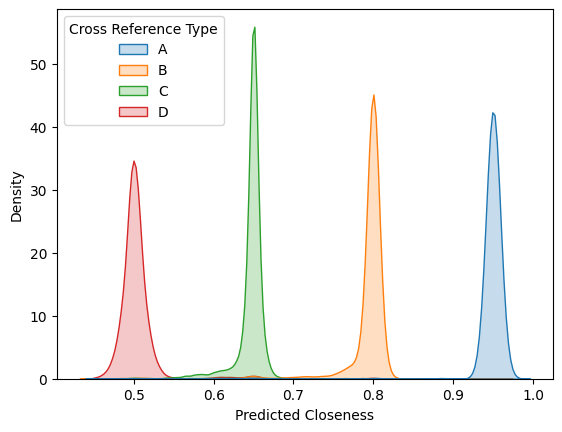

In [ ]:
pipeline.fit(X_train, y_train)
#3min 8s
# Predict and store results
y_pred = pipeline.predict(X_test)
results["Decision Tree"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

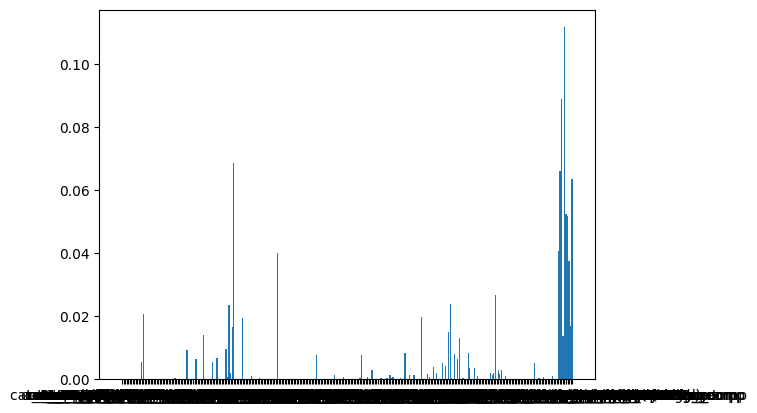

In [ ]:
tree_model = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']
feature_importance = tree_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
plt.bar(feature_names, feature_importance)
plt.show()

In [ ]:
from sklearn.tree import export_text
tree_model = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]  # Fallback if not supported

tree_rules = export_text(tree_model, feature_names=feature_names)

In [ ]:
print(tree_rules)

|--- cat__Supplier_Package_SOIC N <= 0.50
|   |--- remainder__Typical Gain Bandwidth Product <= 0.01
|   |   |--- remainder__Maximum Single Supply Voltage_comp <= 0.20
|   |   |   |--- remainder__Maximum Single Supply Voltage <= 0.19
|   |   |   |   |--- remainder__Minimum Single Supply Voltage <= 0.06
|   |   |   |   |   |--- remainder__Minimum Single Supply Voltage <= 0.05
|   |   |   |   |   |   |--- cat__Supplier_Package_PDIP <= 0.50
|   |   |   |   |   |   |   |--- cat__Supplier_Package_UCSP <= 0.50
|   |   |   |   |   |   |   |   |--- cat__Supplier_Package_comp_DMP <= 0.50
|   |   |   |   |   |   |   |   |   |--- remainder__Typical Gain Bandwidth Product <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- cat__Supplier_Package_SOT-23 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- cat__Supplier_Package_SOT-23 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree sans manufacturer.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [11:25<00:00, 26.76it/s]


'closeness_matrix Decision Tree sans manufacturer.npy'

In [ ]:
data = np.load("closeness_matrix Decision Tree sans manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix Decision tree.png")

In [ ]:
unique_values, counts = np.unique(data, return_counts=True)
print(dict(zip(unique_values, counts)))

{0.45: 127443, 0.4500375: 3195, 0.45004973: 9828, 0.45008096: 6, 0.45009595: 24, 0.45030636: 6, 0.45034412: 80, 0.45034513: 212, 0.45038155: 30, 0.45041078: 9, 0.4504344: 8, 0.4505355: 169, 0.45058158: 363, 0.4506169: 78, 0.45069012: 32, 0.4507478: 2160, 0.4507732: 356, 0.450815: 1080, 0.45082864: 3080, 0.45085084: 14544, 0.45094284: 30, 0.45101067: 260, 0.45102578: 440, 0.4510672: 6, 0.4511268: 725, 0.45119217: 80, 0.45120722: 42, 0.4512888: 6, 0.4513091: 174, 0.45134273: 776, 0.4513465: 15, 0.4514024: 45, 0.4514041: 3, 0.4514135: 82, 0.4514244: 282, 0.45143923: 748, 0.4514397: 81, 0.45144054: 6, 0.45148483: 12, 0.451506: 121910, 0.45151803: 65, 0.4515547: 330, 0.45164216: 6216, 0.4516929: 425, 0.45169616: 66, 0.45170516: 12, 0.45177913: 57, 0.45180783: 280, 0.45185453: 1176, 0.4519465: 24, 0.4519584: 27, 0.45196584: 36, 0.45203516: 87840, 0.4520361: 110, 0.45206562: 30, 0.45212516: 27, 0.4521379: 12, 0.45218638: 384, 0.45219: 748, 0.45227274: 178, 0.4523094: 2, 0.45231482: 408, 0.452

<BarContainer object of 138158 artists>

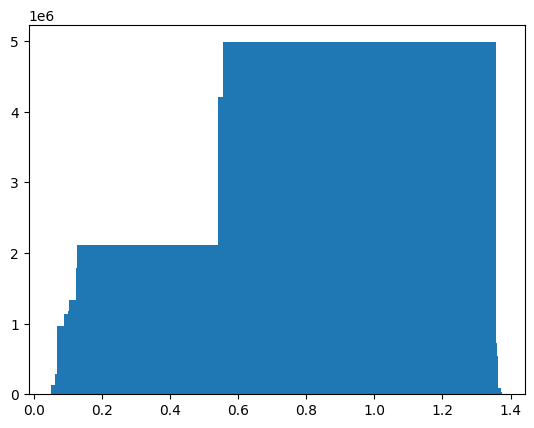

In [ ]:
plt.bar(unique_values, counts)

In [ ]:
sns.histplot(data.diagonal()) #repartition des score de similarité d'un produit avec lui même (doit être proche de 0.9)

KeyboardInterrupt: 

In [ ]:
df_train["Supplier_Package"].value_counts()

,count
Supplier_Package,
SO N,111241
TSSOP,77410
SOT-23,68021
SOIC,67592
MSOP,41656
...,...
PCSP-E3 EP,2
MFP,2
TO-252,2


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        device="cuda"
    ))
])

TypeError: RandomForestRegressor.__init__() got an unexpected keyword argument 'device'

In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Supplier_Package',
                                                   'MANUFACTURER',
                                                   'Supplier_Package_comp',
                                                   'MANUFACTURER_comp'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

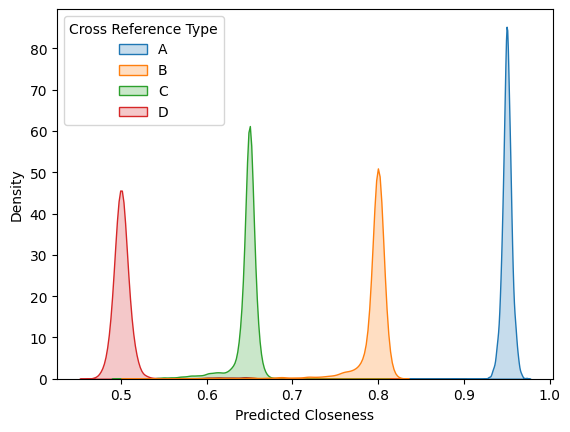

In [ ]:
# Predict and store results
y_pred = pipeline.predict(X_test)
results["Random forest"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt

tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Random Forest.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [1:41:48<00:00,  3.00it/s]


'closeness_matrix Random Forest.npy'

In [ ]:
# prompt: save random forest model

import pickle

# Assuming 'pipeline' is your trained RandomForestRegressor pipeline
filename = 'random_forest_model.pkl'
pickle.dump(pipeline, open(filename, 'wb'))


## Kneighborsregressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=30))
])

In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Supplier_Package',
                                                   'MANUFACTURER',
                                                   'Supplier_Package_comp',
                                                   'MANUFACTURER_comp'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=30))])

In [ ]:
# Predict and store results
y_pred = pipeline.predict(X_test)
results["KNeighborsRegressor"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree.npy")

## XGBOOST

In [ ]:
from xgboost import XGBRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,           # Increase number of trees
        max_depth=10,               # Control tree depth
        learning_rate=0.5,          # Step size for updates
        subsample=0.8,              # Fraction of samples per tree
        colsample_bytree=0.9,       # Fraction of features per tree
        reg_alpha=0.05,              # L1 regularization
        reg_lambda=0.05,             # L2 regularization
        random_state=42  ,           # For reproducibility
        device="cuda"
    ))
])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

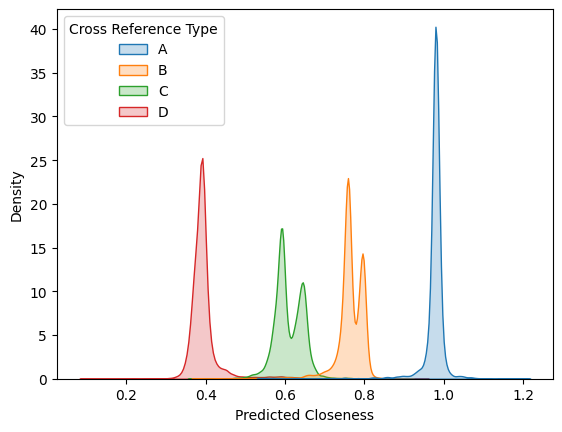

In [ ]:
pipeline.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline.predict(X_test)
results["Xgboost"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
df_test["Predicted Closeness clipped"] = df_test["Predicted Closeness"].clip(0,1)

<Axes: xlabel='Closeness', ylabel='Density'>

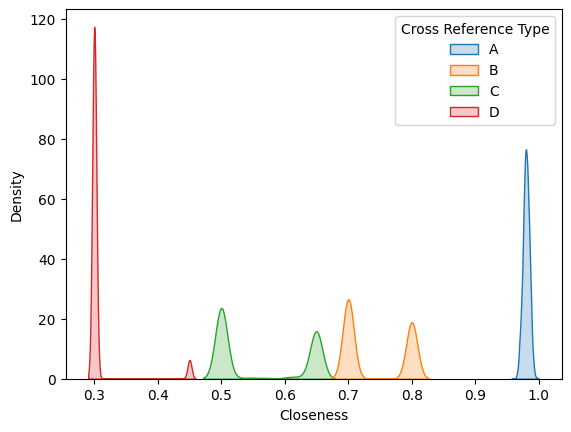

In [ ]:
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness clipped', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
# importlib.reload(tt)
name = "closeness_matrix XGBRegressor no_manufacturer new dist exponentielle k01.npy"
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path=name)

Building closeness matrix: 100%|██████████| 18352/18352 [18:29<00:00, 16.55it/s]


'closeness_matrix XGBRegressor no_manufacturer new dist exponentielle k01.npy'

In [ ]:
import numpy as np
importlib.reload(tt)
data = np.load(name, mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
#requires 8gb ram free
vz.export_matrix_downscaled(data,name="Xgboost dist exponentielle k01")

Downscaling from (18352, 18352) to (10000, 10000) ...
Saved Xgboost dist exponentielle k01 at ~(10000x10000) px, dpi=500.


In [ ]:
# requires 80gb ram
# import helper_functions.visualize as vz
# import importlib
# importlib.reload(vz)
# vz.export_matrix(data , "matrix Xgboost.png")

## LightGBM

In [ ]:
from lightgbm import LGBMRegressor

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.5,
        colsample_bytree=0.8,
        random_state=42
    ))
])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 490523, number of used features: 289
[LightGBM] [Info] Start training from score 0.647107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='Predicted Closeness', ylabel='Density'>

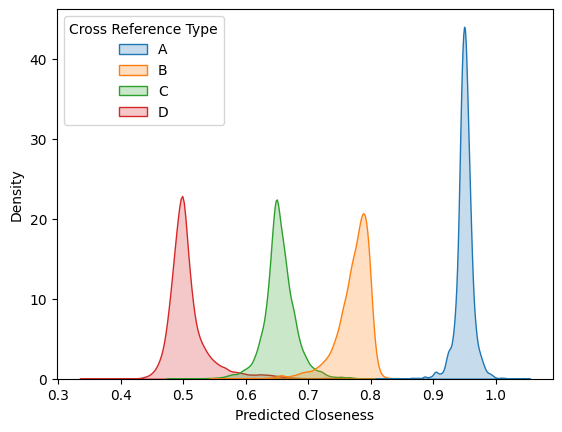

In [ ]:
pipeline_lgbm.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_lgbm.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_lgbm, output_path="closeness_matrix LGBMRegressor.npy")

## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.1,
        subsample=0.8,          # Stochastic gradient boosting
        random_state=42,
    ))
])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

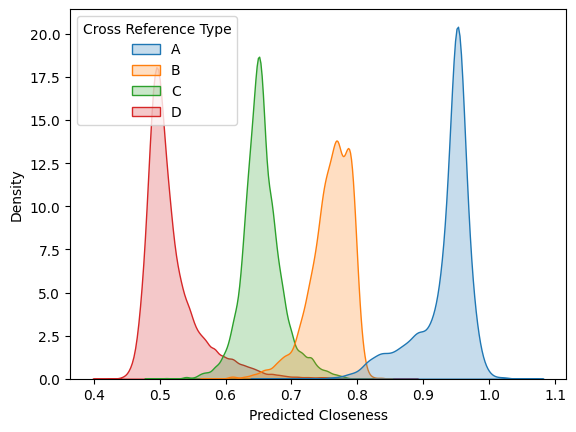

In [ ]:
pipeline_gb.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_gb.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_gb, output_path="closeness_matrix GradientBoostingRegressor no manufacturer.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [1:20:35<00:00,  3.80it/s]


'closeness_matrix GradientBoostingRegressor no manufacturer.npy'

In [ ]:
data = np.load("closeness_matrix GradientBoostingRegressor no manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix GradientBoostingRegressor.png")

## SVR

In [ ]:
from sklearn.svm import SVR

pipeline_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(
        kernel='rbf',          # Radial basis function kernel
        C=1.0,                 # Regularization parameter
        epsilon=0.1            # Margin of tolerance
    ))
])

In [ ]:
pipeline_svr.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_svr.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_svr, output_path="closeness_matrix SVR.npy")

## Ridge

In [ ]:
from sklearn.linear_model import Ridge

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(
        alpha=1.0             # Regularization strength
    ))
])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

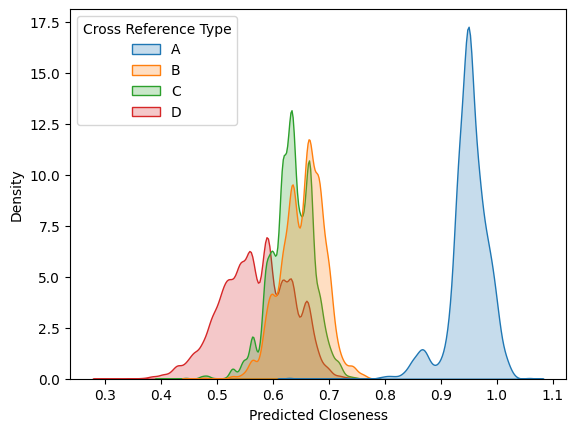

In [ ]:
pipeline_ridge.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_ridge.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_ridge, output_path="closeness_matrix Ridge.npy")

Building closeness matrix:  95%|█████████▍| 17421/18352 [08:15<00:24, 37.47it/s]

# Deep Learning

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


import os  # File handling
import random  # Randomization
import time  # Time tracking
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
prefix_dict = {
    'Supplier_Package': 'pkg',
    'MANUFACTURER': 'mf',
    'Supplier_Package_comp': 'pkg_comp',
    'MANUFACTURER_comp': 'mf_comp'
}
categorical_columns = ['Supplier_Package', 'MANUFACTURER', 'Supplier_Package_comp', 'MANUFACTURER_comp']

one hot encode entire dataset

In [ ]:
df_encoded =pd.get_dummies(df,columns=categorical_columns , prefix = prefix_dict,drop_first=True)

In [ ]:
df_encoded[df_encoded == 0] = -1

split

In [ ]:
df_train_encoded, df_validation_encoded, df_test_encoded = pp.split_dataframe(df_encoded)

In [ ]:
df_train_encoded = pp.balance_training_data(df_train_encoded,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})

In [ ]:
columns_to_drop

['Closeness', 'MPN', 'MPN_comp', 'Mean', 'Std', 'Cross Reference Type']

drop unnecessary columns and split

In [ ]:
df_train_encoded.columns

RangeIndex(start=0, stop=203, step=1)

In [ ]:
X_train_encoded = df_train_encoded.drop(columns=columns_to_drop)
X_validation_encoded = df_validation_encoded.drop(columns=columns_to_drop)
X_test_encoded = df_test_encoded.drop(columns=columns_to_drop)

y_train = df_train_encoded['Closeness']
y_validation = df_validation_encoded['Closeness']
y_test = df_test_encoded['Closeness']

KeyError: "['Closeness', 'MPN', 'MPN_comp', 'Mean', 'Std', 'Cross Reference Type'] not found in axis"

In [ ]:
X_train_tensor= torch.tensor(X_train_encoded.to_numpy(dtype=np.float32),device=device)
X_test_tensor = torch.tensor(X_test_encoded.to_numpy(dtype=np.float32),device=device)
X_val_tensor = torch.tensor(X_validation_encoded.to_numpy(dtype=np.float32),device=device)
y_train_tensor = torch.tensor(y_train.to_numpy(dtype=np.float32),device=device)
y_test_tensor = torch.tensor(y_test.to_numpy(dtype=np.float32),device=device)
y_val_tensor = torch.tensor(y_validation.to_numpy(dtype=np.float32),device=device)

NameError: name 'torch' is not defined

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

NameError: name 'TensorDataset' is not defined

In [ ]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
a,b = next(iter(test_loader))
print(a.shape,b.shape)

In [ ]:
b.shape

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, dropout):
        super(MLP, self).__init__()

        layers = []
        current_size = hidden_size

        layers.append(nn.Linear(input_size, current_size))
        layers.append(nn.BatchNorm1d(current_size))  # Normalize activations
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        for _ in range(n_layers - 1):
            next_size = max(current_size // 2, output_size)
            layers.append(nn.Linear(current_size, next_size))
            layers.append(nn.BatchNorm1d(next_size))  # Normalize activations
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            current_size = next_size

        layers.append(nn.Linear(current_size, output_size))
        layers.append(nn.Identity())  # No activation in regression

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
X_train_tensor.shape[1]

380

In [ ]:
input_dim = X_train_tensor.shape[1]
model = MLP(input_dim,1 , 128,4,0.2).to(device)
model

MLP(
  (model): Sequential(
    (0): Linear(in_features=380, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=16, out_features=1, bias=True)
    (17): Identity()
  )
)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

In [ ]:
from tqdm import tqdm
num_epochs = 50

In [ ]:

for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch_X, batch_y in tqdm(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        # print(outputs)
        # print(batch_y)
        loss = criterion(outputs, batch_y)
        # print(loss)
        loss.backward()
        optimizer.step()
        # break

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in validation_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()

    val_loss /= len(validation_loader)  # Average MSE
    print(f'Epoch {epoch+1}/{num_epochs}, Validation MSE: {val_loss:.4f}')

    # Update learning rate
    scheduler.step(val_loss)

100%|██████████| 1599/1599 [00:12<00:00, 126.55it/s]


Epoch 1/50, Validation MSE: 0.0089


100%|██████████| 1599/1599 [00:11<00:00, 139.82it/s]


Epoch 2/50, Validation MSE: 0.0089


 29%|██▉       | 464/1599 [00:03<00:07, 154.00it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
predictions = []
with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader):
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy().flatten())
df_test['Predicted Closeness'] = predictions

(0.2, 1.2)

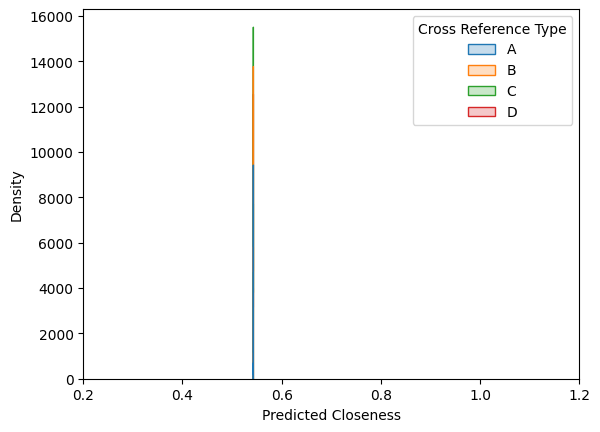

In [ ]:
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)
plt.xlim(0.2, 1.2)  # Sets the visible x-axis limits to [0, 1]

<Axes: xlabel='Closeness', ylabel='Count'>

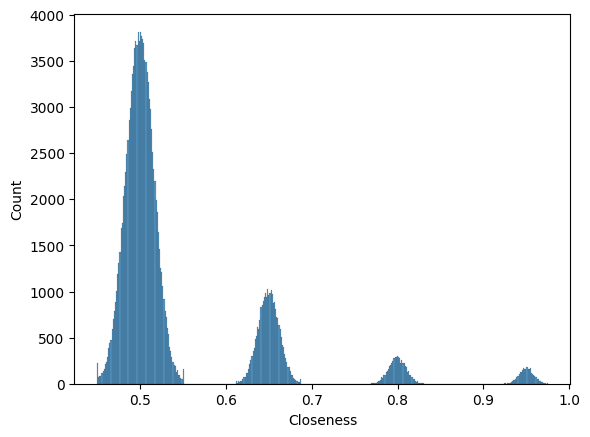

In [ ]:
sns.histplot(x=y_test)